In [1]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

/media/hdd/.conda-envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


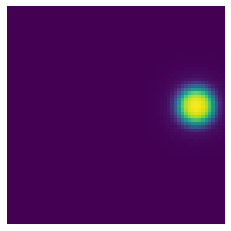

In [32]:
dataset.update()
images = dataset()
# The first entry contains all frames in a big tensor, the rest of the entries is each frame
for img in images[1:]:
    print(img.shape)
dataset.plot()

In [38]:
import tensorflow as tf

from tensorflow.keras.layers import Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
    
    def build(self, input_shape):
        self.weights_linear = self.add_weight(name="weight_linear", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        self.bias_linear = self.add_weight(name="bias_linear", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        self.weights_periodic = self.add_weight(name="weight_periodic", shape=(int(self.seq_len,)), initializer="uniform", trainable=True)
        self.bias_periodic = self.add_weight(name="bias_periodic", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        
    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        
        return tf.concat([time_linear, time_periodic], axis=-1)

In [41]:
from tensorflow.keras.layers import Dense

class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        self.d_k = d_k
        self.d_v = d_v
    
    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
        self.key   = Dense(self.d_k, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
    
    def call(self, inputs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        
        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.softmax(attn_weights, axis=-1)
        
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out